## Task 1

### Importing Libraries

In [1]:
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load the MNIST dataset from the datasets library
mnist = load_dataset('mnist')
print(mnist)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [3]:
def preprocess(data):
    images = np.array(data['image']) / 255.0 ; # Normalize the pixel values
    images = images.reshape(images.shape[0],-1) # Flatten the images
    labels = np.array(data['label'])
    return images, labels

X_train, y_train = preprocess(mnist['train'])
X_test, y_test = preprocess(mnist['test'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [4]:
indices = np.random.choice(X_train.shape[0], 200, replace=False) # Randomly sample 200 images
X_labeled , y_labeled = X_train[indices], y_train[indices]

mask = np.ones(X_train.shape[0], dtype=bool)
mask[indices] = False
X_unlabeled, y_unlabeled = X_train[mask], y_train[mask]

print(f'Labeled: {X_labeled.shape}, {y_labeled.shape}')
print(f'Unlabeled: {X_unlabeled.shape}, {y_unlabeled.shape}')

Labeled: (200, 784), (200,)
Unlabeled: (59800, 784), (59800,)


## Task 2

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
clf = RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(X_labeled, y_labeled)

RandomForestClassifier(random_state=0)

Iteration 1, Accuracy: 0.7794
Iteration 2, Accuracy: 0.7727
Iteration 3, Accuracy: 0.7774
Iteration 4, Accuracy: 0.7701
Iteration 5, Accuracy: 0.7752
Iteration 6, Accuracy: 0.7850
Iteration 7, Accuracy: 0.7818
Iteration 8, Accuracy: 0.7830
Iteration 9, Accuracy: 0.7799
Iteration 10, Accuracy: 0.7798
Iteration 11, Accuracy: 0.7750
Iteration 12, Accuracy: 0.7777
Iteration 13, Accuracy: 0.7735
Iteration 14, Accuracy: 0.7773
Iteration 15, Accuracy: 0.7694
Iteration 16, Accuracy: 0.7722
Iteration 17, Accuracy: 0.7793
Iteration 18, Accuracy: 0.7762
Iteration 19, Accuracy: 0.7685
Iteration 20, Accuracy: 0.7813
Time taken: 14.53s


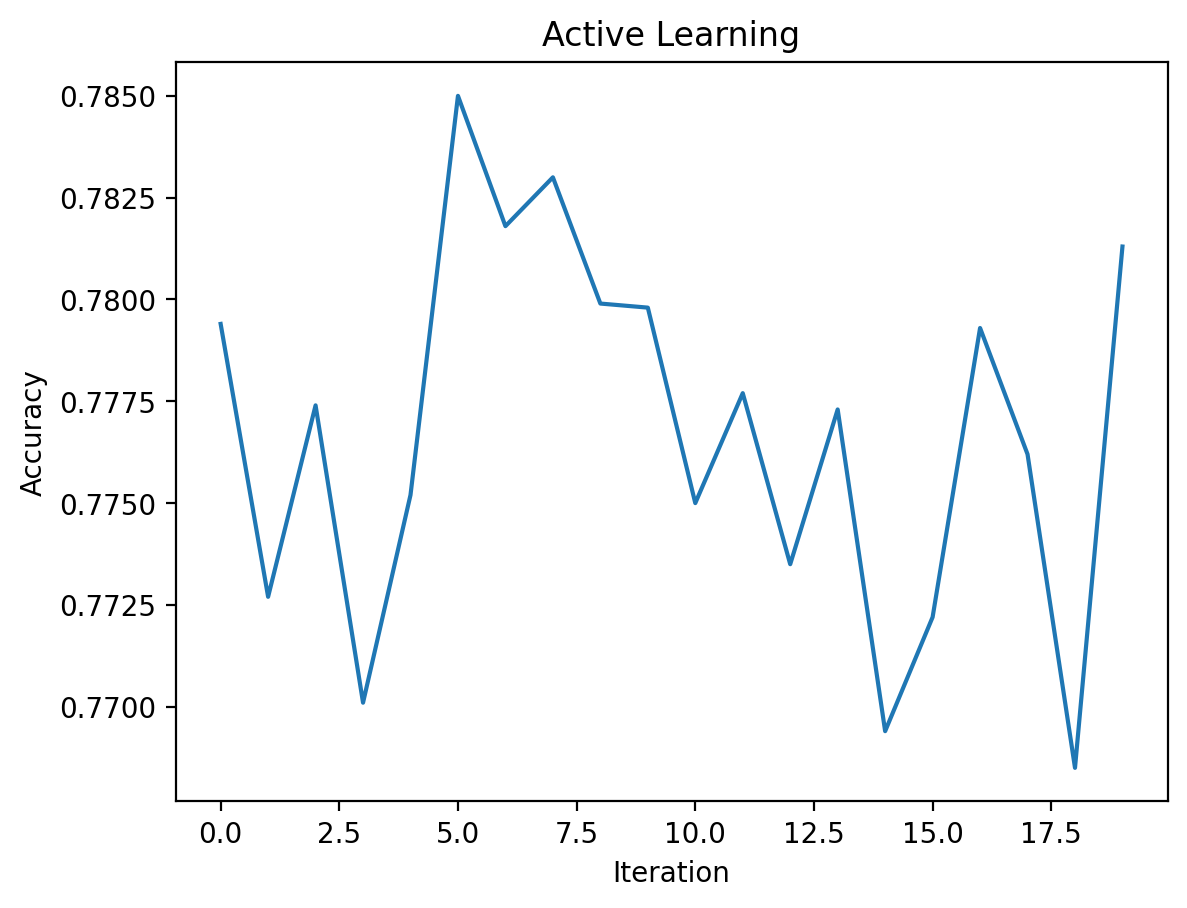

In [7]:
accuracies_random = []

start_time_random = time.time()
for i in range(20):

    # Randomly sample an image from the unlabeled dataset
    index = np.random.choice(X_unlabeled.shape[0])
    X_sample = X_unlabeled[index]
    y_sample = y_unlabeled[index]

    # Add the newly labeled sample to the labeled dataset
    X_labeled = np.vstack([X_labeled, X_sample])
    y_labeled = np.hstack([y_labeled, y_sample])

    # Remove the newly labeled sample from the unlabeled dataset
    X_unlabeled = np.delete(X_unlabeled, index, axis=0)
    y_unlabeled = np.delete(y_unlabeled, index)
    

    # Retrain the classifier
    clf.fit(X_labeled, y_labeled)

    # Evaluate the classifier
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_random.append(acc)

    print(f'Iteration {i+1}, Accuracy: {acc:.4f}')
end_time = time.time()

print(f'Time taken: {end_time - start_time_random:.2f}s')

plt.plot(accuracies_random)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Active Learning')
plt.show()

## Task 3

### Label Entropy based sampling
The label entropy measures the uncertainty in class labels and is given by:

$$
H(Y) = - \sum_{i=1}^{C} p(y_i) \log p(y_i)
$$

where:
- $C$ is the number of classes,
- $p(y_i)$ is the probability of class $y_i$.

Iteration 1, Accuracy: 0.7807
Iteration 2, Accuracy: 0.7845
Iteration 3, Accuracy: 0.7921
Iteration 4, Accuracy: 0.7933
Iteration 5, Accuracy: 0.7945
Iteration 6, Accuracy: 0.7906
Iteration 7, Accuracy: 0.7878
Iteration 8, Accuracy: 0.7912
Iteration 9, Accuracy: 0.8044
Iteration 10, Accuracy: 0.8014
Iteration 11, Accuracy: 0.8106
Iteration 12, Accuracy: 0.8110
Iteration 13, Accuracy: 0.8032
Iteration 14, Accuracy: 0.7992
Iteration 15, Accuracy: 0.8052
Iteration 16, Accuracy: 0.8052
Iteration 17, Accuracy: 0.8059
Iteration 18, Accuracy: 0.8059
Iteration 19, Accuracy: 0.8029
Iteration 20, Accuracy: 0.8015
Time taken: 76.77s


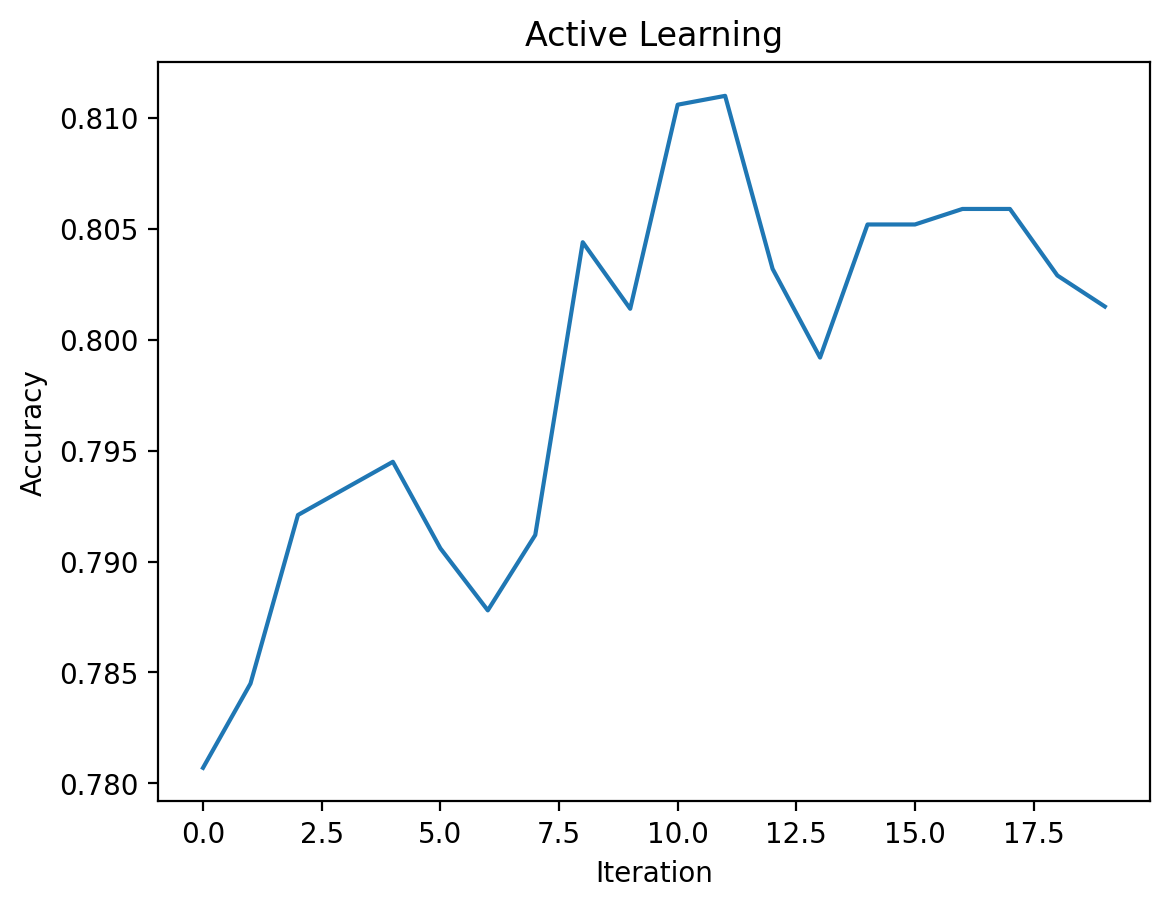

In [8]:
def compute_label_entropy(probs):
    entropy = -np.sum(probs * np.log(probs + 1e-10))
    return entropy

clf = RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(X_labeled, y_labeled)

accuracies_maxentropy = []

start_time_maxentropy = time.time()
for i in range(20):
    # Compute the class probabilities for each sample in the unlabeled dataset
    probs = clf.predict_proba(X_unlabeled)

    # Compute the entropy for each sample
    entropies = np.array([compute_label_entropy(p) for p in probs])

    # Select the sample with the highest entropy - most uncertain prediction
    index = np.argmax(entropies)
    X_sample = X_unlabeled[index]
    y_sample = y_unlabeled[index]

    # Add the newly labeled sample to the labeled dataset
    X_labeled = np.vstack([X_labeled, X_sample])
    y_labeled = np.hstack([y_labeled, y_sample])

    # Remove the newly labeled sample from the unlabeled dataset
    X_unlabeled = np.delete(X_unlabeled, index, axis=0)
    y_unlabeled = np.delete(y_unlabeled, index)

    # Retrain the classifier
    clf.fit(X_labeled, y_labeled)

    # Evaluate the classifier
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_maxentropy.append(acc)

    print(f'Iteration {i+1}, Accuracy: {acc:.4f}')

end_time_maxentropy = time.time()
print(f'Time taken: {end_time_maxentropy - start_time_maxentropy:.2f}s')


plt.plot(accuracies_maxentropy)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Active Learning')
plt.show()

## Task 4

### Vote Entropy based sampling
Vote entropy is used in active learning to quantify uncertainty in predictions from multiple models:

$$
H_V(x) = - \sum_{i=1}^{C} \frac{v_i}{V} \log \frac{v_i}{V}
$$

where:
- $V$ is the total number of votes,
- $v_i$ is the number of votes for class $i$,
- $C$ is the number of classes.

Iteration 1, Accuracy: 0.8009
Iteration 2, Accuracy: 0.8061
Iteration 3, Accuracy: 0.8070
Iteration 4, Accuracy: 0.8071
Iteration 5, Accuracy: 0.8077
Iteration 6, Accuracy: 0.8089
Iteration 7, Accuracy: 0.8105
Iteration 8, Accuracy: 0.8085
Iteration 9, Accuracy: 0.8112
Iteration 10, Accuracy: 0.8072
Iteration 11, Accuracy: 0.8073
Iteration 12, Accuracy: 0.8060
Iteration 13, Accuracy: 0.8008
Iteration 14, Accuracy: 0.8113
Iteration 15, Accuracy: 0.8053
Iteration 16, Accuracy: 0.8060
Iteration 17, Accuracy: 0.8225
Iteration 18, Accuracy: 0.8166
Iteration 19, Accuracy: 0.8172
Iteration 20, Accuracy: 0.8135
Time taken: 357.04s


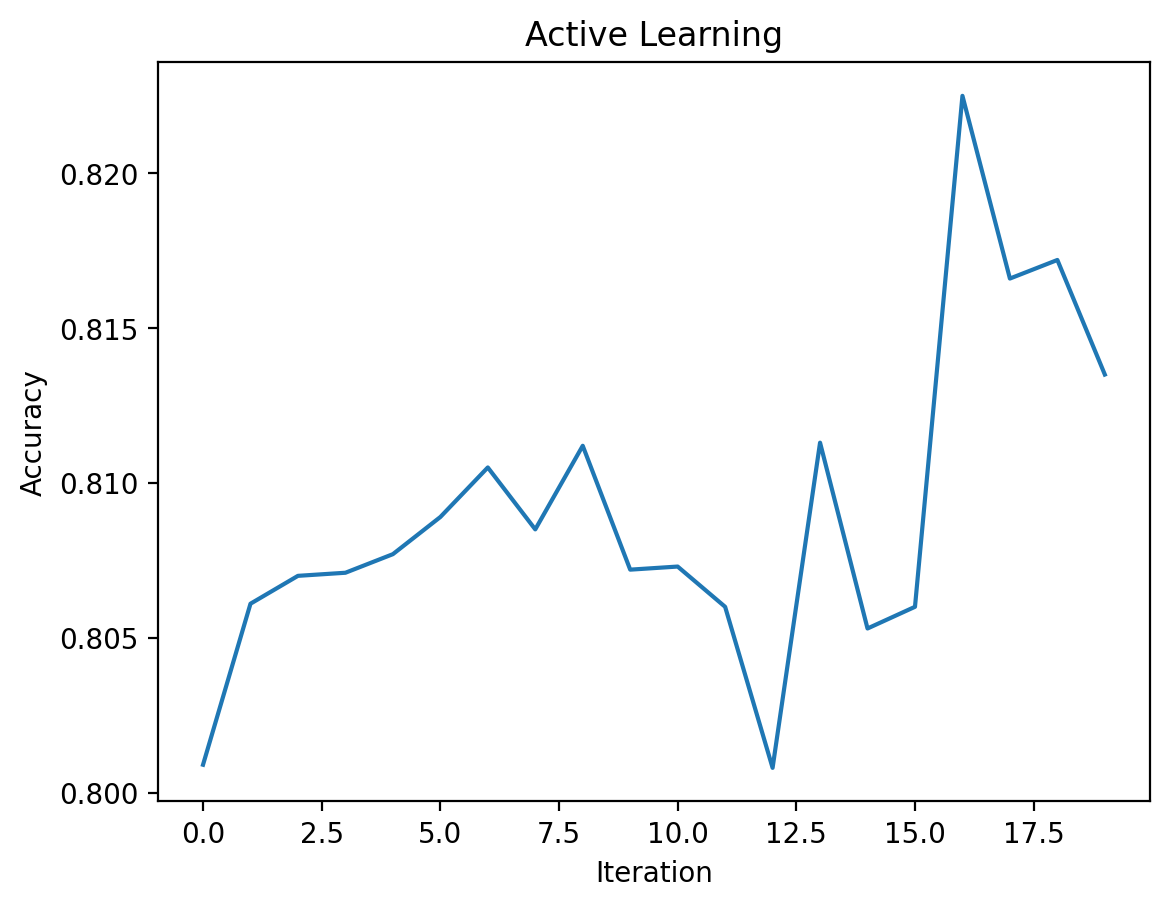

In [9]:
from sklearn.utils import resample , shuffle

# function to calculate vote entropy
def compute_vote_entropy(predictions):
    num_classes = np.max(predictions) + 1
    probs = np.zeros((predictions.shape[0], num_classes))
    for i in range(predictions.shape[0]):
        counts = np.bincount(predictions[i], minlength=num_classes) # count the votes for each class
        probs[i] = counts / np.sum(counts) # compute the class probabilities

    entropies = np.array([compute_label_entropy(p) for p in probs])
    return entropies

# initialize the committee
committee = [RandomForestClassifier(n_estimators=100, random_state=0) for _ in range(5)]

for clf in committee:
    clf.fit(X_labeled, y_labeled)

accuracies_committee = []

start_time_committee = time.time()
for i in range(20):
    # compute the class probabilities for each sample in the unlabeled dataset
    predictions = np.array([clf.predict(X_unlabeled) for clf in committee])
    predictions = predictions.T

    # compute the vote entropy for each sample
    entropies = compute_vote_entropy(predictions)

    # select the sample with the highest vote entropy
    index = np.argmax(entropies)

    # Query the true label for the selected sample
    X_sample = X_unlabeled[index]
    y_sample = y_unlabeled[index]
    
    # Add the newly labeled sample to the labeled dataset
    X_labeled = np.vstack([X_labeled, X_sample])
    y_labeled = np.hstack([y_labeled, y_sample])

    # Remove the newly labeled sample from the unlabeled dataset
    X_unlabeled = np.delete(X_unlabeled, index, axis=0)
    y_unlabeled = np.delete(y_unlabeled, index)

    # Retrain the committee
    for clf in committee:
        clf.fit(X_labeled, y_labeled)

    # Evaluate the committee
    predictions = np.array([clf.predict(X_test) for clf in committee])
    predictions = predictions.T
    y_pred = np.array([np.argmax(np.bincount(p)) for p in predictions])
    acc = accuracy_score(y_test, y_pred)
    accuracies_committee.append(acc)

    print(f'Iteration {i+1}, Accuracy: {acc:.4f}')
end_time_committee = time.time()

print(f'Time taken: {end_time_committee - start_time_committee:.2f}s')

plt.plot(accuracies_committee)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Active Learning')
plt.show()

## Task 5

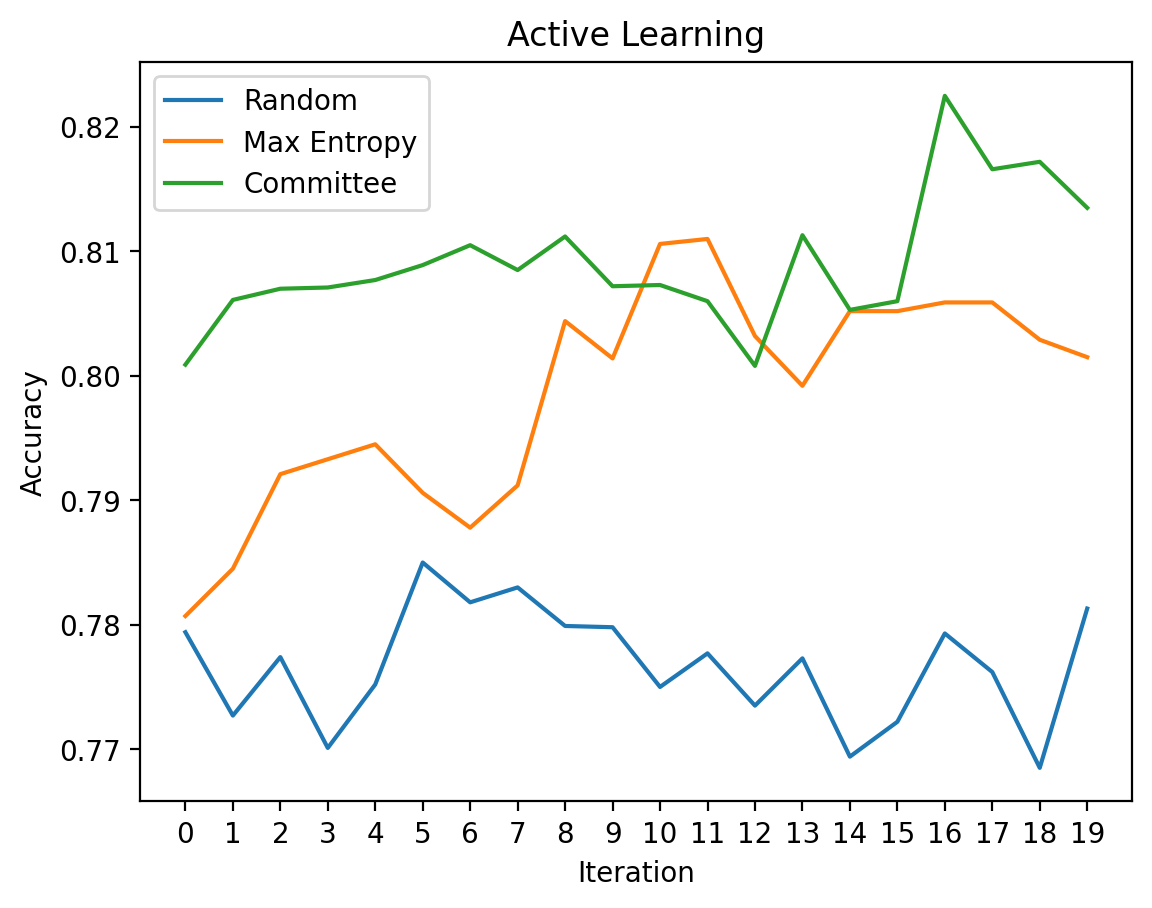

In [11]:
# plot the accuracies of all three active learning strategies
plt.plot(accuracies_random, label='Random')
plt.plot(accuracies_maxentropy, label='Max Entropy')
plt.plot(accuracies_committee, label='Committee')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, 20))
plt.title('Active Learning')
plt.legend()
plt.show()

### Report: Active Learning Strategy Comparison

#### Final Accuracy
- Max Entropy and Committee-Based Sampling generally outperform Random Sampling.
- Committee-Based Sampling may achieve the highest accuracy, but it requires more computational resources.

#### Cost-Effectiveness
- Random Sampling is inefficient as it does not prioritize difficult samples.
- Max Entropy provides a strong balance between accuracy and cost.
- Committee-Based Sampling, while powerful, is computationally expensive.

#### Limitations
- If the dataset is small, entropy-based methods might not be as effective.
- Committee-based approaches require multiple models, increasing complexity.